In [1]:
# %load C:\Users\walter\Desktop\tools\plot_template.py

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=14, color='grey')
plt.rc('ytick', labelsize=14, color='grey')
plt.rc('legend', fontsize=16, loc='lower left')
plt.rc('figure', titlesize=18)
plt.rc('savefig', dpi=330, bbox='tight')
%matplotlib inline


In [2]:
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
import os
import matplotlib

## util functions

In [4]:
def read_data(data_type, building_type, csv_file):
    '''
    data_type: 'ami' or 'model'
    building_type: 'medium_office', 'outpatient'
    csv_file: 'cluster_centers', 'cluster_result', 'statistics'    
    '''
    path_fun = lambda data_type:'data/{}_time_domain/{}-{}'.format(data_type, data_type, building_type)
    data = pd.read_csv(path_fun(data_type)+'/{}.csv'.format(csv_file), index_col=0)
    return data

## cluster center

In [5]:
building_type = 'medium_office'

In [6]:
ami_cluster_center = read_data('ami', building_type, 'cluster_centers').T
model_cluster_center = read_data('model', building_type, 'cluster_centers').T

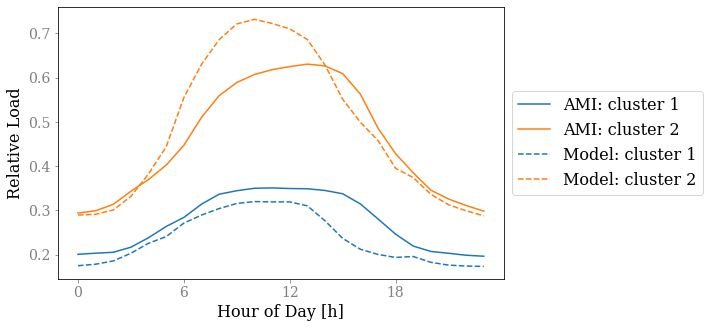

In [7]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(ami_cluster_center.index, ami_cluster_center[0], 
        label='AMI: cluster 1', color=default_colors[0], ls='-')
ax.plot(ami_cluster_center.index, ami_cluster_center[1], 
        label='AMI: cluster 2', color=default_colors[1], ls='-')
ax.plot(model_cluster_center.index, model_cluster_center[0], 
        label='Model: cluster 1', color=default_colors[0], ls='--')
ax.plot(model_cluster_center.index, model_cluster_center[1], 
        label='Model: cluster 2', color=default_colors[1], ls='--')
ax.set_xlabel('Hour of Day [h]')
ax.set_ylabel('Relative Load')
ax.set_xticks(np.arange(0, 24, 6))

plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.savefig(os.path.join('fig','validation',f'explore_{building_type}','cluster_center'))

## cluster proportion

In [8]:
ami_cluster_result = read_data('ami', building_type, 'cluster_result')
model_cluster_result = read_data('model', building_type, 'cluster_result')

In [9]:
def long_to_short(dataframe, field):
    '''
    Index is date, columns is each building, value is the value of the field
    '''
    short_df = pd.DataFrame()

    for building in dataframe['building_ID'].unique():
        data = dataframe[dataframe['building_ID']==building][[field,'date']]
        data.set_index('date', inplace=True)
        data.rename(columns={field:building}, inplace=True)
        short_df = pd.concat([short_df, data], axis=1)
    
    return short_df

In [10]:
ami_cluster_result_short = long_to_short(ami_cluster_result, '2_clusters')
model_cluster_result_short = long_to_short(model_cluster_result, '2_clusters')

In [11]:
from matplotlib.colors import ListedColormap

In [12]:
fig, (ax0, ax1) = plt.subplots(1, 2, sharey=True, figsize=(12,7), 
                               gridspec_kw={'width_ratios': [1, 3]})
col_dict={0:default_colors[0],
          1:default_colors[1]}
cmap = ListedColormap([col_dict[x] for x in col_dict.keys()])

labels = np.array(["Cluster 1","Cluster 2"])
len_lab = len(labels)

# prepare normalizer
## Prepare bins for the normalizer
norm_bins = np.sort([*col_dict.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
print(norm_bins)
## Make normalizer and formatter
norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2

c = ax0.pcolor(ami_cluster_result_short.values, cmap=cmap, norm=norm)
ax1.pcolor(model_cluster_result_short.values, cmap=cmap, norm=norm)
ax0.set_title('AMI Data', fontsize=16)
ax1.set_title('Model Result', fontsize=16)
ax0.set_ylabel('Day of Year')
ax0.set_xlabel('Building ID')
ax1.set_xlabel('Building ID')

fig.colorbar(c, format=fmt, ticks=tickz)
plt.savefig(os.path.join('fig','validation',f'explore_{building_type}','clustering heat map'))

[-0.5  0.5  1.5]


,2_clusters,3_clusters,4_clusters,5_clusters,6_clusters,7_clusters,building_ID,data_type,date,day_of_week,holiday
0,0,0,1,1,1,2,8604214001,ami,2017-01-01 00:00:00-07:00,Sunday,False
1,0,0,1,1,1,2,8604214001,ami,2017-01-02 00:00:00-07:00,Monday,True
2,1,1,1,2,2,3,8604214001,ami,2017-01-03 00:00:00-07:00,Tuesday,False
3,1,1,2,2,3,4,8604214001,ami,2017-01-04 00:00:00-07:00,Wednesday,False
4,1,1,2,2,3,4,8604214001,ami,2017-01-05 00:00:00-07:00,Thursday,False


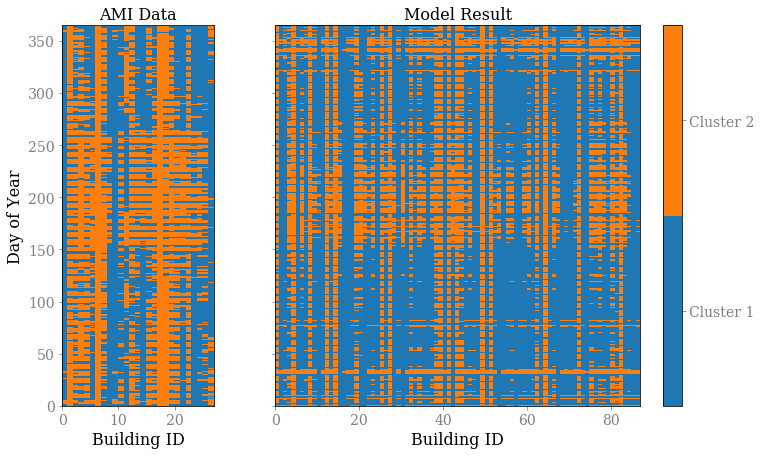

In [13]:
ami_cluster_result.head()

In [14]:
ami_cluster_result['non_working_day'] = (ami_cluster_result['day_of_week']=='Sunday') | \
                                        (ami_cluster_result['day_of_week']=='Saturday') | \
                                        (ami_cluster_result['holiday']==True)

In [15]:
model_cluster_result['non_working_day'] = (model_cluster_result['day_of_week']=='Sunday') | \
                                        (model_cluster_result['day_of_week']=='Saturday') | \
                                        (model_cluster_result['holiday']==True)

In [16]:
ami_cluster_pct = pd.DataFrame()

for building in ami_cluster_result['building_ID'].unique():
    data = ami_cluster_result[ami_cluster_result['building_ID'] == building]
    data_pct = pd.DataFrame(data=data.groupby('non_working_day')['2_clusters'].mean())
    data_pct.columns=[building]
    ami_cluster_pct = pd.concat([ami_cluster_pct, data_pct], axis=1)
    
model_cluster_pct = pd.DataFrame()

for building in model_cluster_result['building_ID'].unique():
    data = model_cluster_result[model_cluster_result['building_ID'] == building]
    data_pct = pd.DataFrame(data=data.groupby('non_working_day')['2_clusters'].mean())
    data_pct.columns=[building]
    model_cluster_pct = pd.concat([model_cluster_pct, data_pct], axis=1)

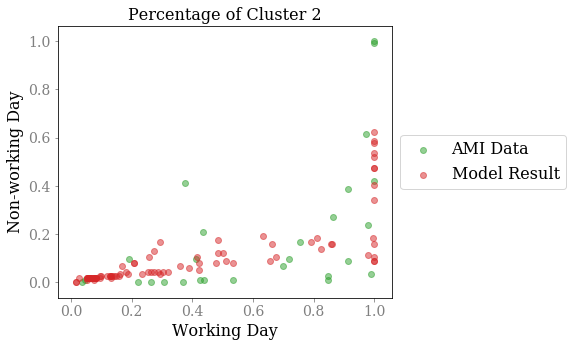

In [17]:
fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(ami_cluster_pct.loc[False], ami_cluster_pct.loc[True], color=default_colors[2], label='AMI Data', alpha=0.5)
ax.scatter(model_cluster_pct.loc[False], model_cluster_pct.loc[True], 
           color=default_colors[3], label='Model Result', alpha=0.5)
ax.set_xlabel('Working Day')
ax.set_ylabel('Non-working Day')
ax.legend(loc='center left', bbox_to_anchor=(1,0.5))
ax.set_title('Percentage of Cluster 2', fontsize=16)
plt.savefig(os.path.join('fig','validation',f'explore_{building_type}','cluster scatter'))

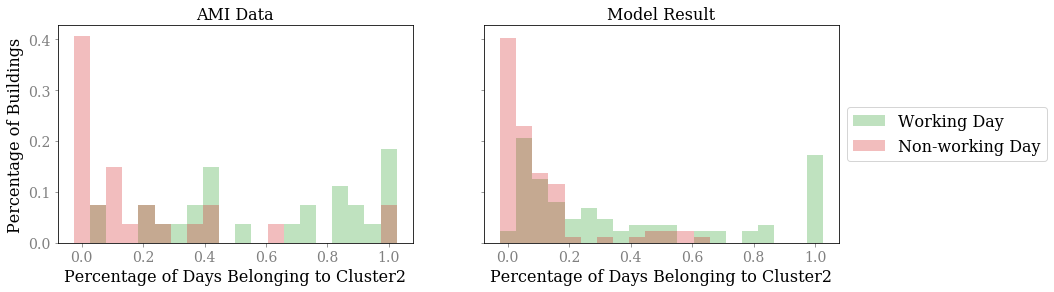

In [18]:
bins = np.linspace(-0.025,1.025,21)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(14,4))
axs[0].hist(ami_cluster_pct.loc[False], bins, alpha=0.3, label='Working Day', color=default_colors[2], 
         weights=np.ones(len(ami_cluster_pct.loc[False]))/len(ami_cluster_pct.loc[False]))
axs[0].hist(ami_cluster_pct.loc[True], bins, alpha=0.3, label='Non-working Day', color=default_colors[3],
         weights=np.ones(len(ami_cluster_pct.loc[False]))/len(ami_cluster_pct.loc[False]))

axs[1].hist(model_cluster_pct.loc[False], bins, alpha=0.3, label='Working Day', color=default_colors[2], 
         weights=np.ones(len(model_cluster_pct.loc[False]))/len(model_cluster_pct.loc[False]))
axs[1].hist(model_cluster_pct.loc[True], bins, alpha=0.3, label='Non-working Day', color=default_colors[3],
         weights=np.ones(len(model_cluster_pct.loc[False]))/len(model_cluster_pct.loc[False]))
axs[0].set_title('AMI Data', fontsize=16)
axs[1].set_title('Model Result', fontsize=16)

axs[0].set_ylabel('Percentage of Buildings')
axs[0].set_xlabel('Percentage of Days Belonging to Cluster2')
axs[1].set_xlabel('Percentage of Days Belonging to Cluster2')
axs[1].legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.savefig(os.path.join('fig','validation',f'explore_{building_type}','cluster percentage'))

In [19]:
ami_cluster_pct.head()

,8604214001,8605118001,8606207901,8606218001,8717420001,8718207001,8730406001,8731114003,8731186001,9701212901,...,9711471220,9712343100,9714107901,9725267003,9726133009,9726133012,9726141002,9726143002,9728400906,9736274001
non_working_day,,,,,,,,,,,,,,,,,,,,,
False,0.036,1.000000,0.848000,0.912000,0.848000,0.436000,1,0.86400,0.22,0.048000,...,1.000000,0.972000,0.980000,0.720000,0.412000,0.988000,0.264,0.424000,0.368,0.192000
True,0.000,0.421053,0.008772,0.385965,0.026316,0.210526,1,0.27193,0.00,0.008772,...,0.991228,0.614035,0.236842,0.096491,0.096491,0.035088,0.000,0.008772,0.000,0.096491


## Distribution of key statistics

In [20]:
ami_cluster_stat = read_data('ami', building_type, 'statistics')
model_cluster_stat = read_data('model', building_type, 'statistics')

In [21]:
ami_cluster_stat = pd.concat([ami_cluster_stat, ami_cluster_result[['2_clusters','non_working_day']]], axis=1)
model_cluster_stat = pd.concat([model_cluster_stat, model_cluster_result[['2_clusters','non_working_day']]], axis=1)

In [22]:
ami_cluster_stat.head()

,highLoad,highLoad_SD,baseLoad,baseLoad_SD,Morning Rise Start,High Load Start,High Load Finish,Afternoon Fall Finish,highLoadDuration,riseTime,fallTime,Base To Peak Ratio,building_ID,data_type,date,day_of_week,holiday,2_clusters,non_working_day
0,0.588940,0.222031,0.131823,0.368521,15,16,35,76,4.75,0.25,10.25,0.223830,8604214001,ami,2017-01-01 00:00:00-07:00,Sunday,False,0,True
1,0.570546,0.223397,0.147210,0.248593,16,17,35,77,4.50,0.25,10.50,0.258016,8604214001,ami,2017-01-02 00:00:00-07:00,Monday,True,0,True
2,0.513951,0.169237,0.181224,0.186226,11,14,73,77,14.75,0.75,1.00,0.352610,8604214001,ami,2017-01-03 00:00:00-07:00,Tuesday,False,1,False
3,0.570950,0.124671,0.195151,0.198899,9,17,73,77,14.00,2.00,1.00,0.341800,8604214001,ami,2017-01-04 00:00:00-07:00,Wednesday,False,1,False
4,0.591188,0.186811,0.233529,0.208773,0,7,72,77,16.25,1.75,1.25,0.395016,8604214001,ami,2017-01-05 00:00:00-07:00,Thursday,False,1,False


In [23]:
ami_data = ami_cluster_stat
model_data = model_cluster_stat

In [24]:
def plot_dist(ami_data, model_data, field, x_label, y_label, figName, bins_method='max',time_stick=False):
    if time_stick:
        bins = np.linspace(-1, 97, 49)
        
    else:
    
        if bins_method == 'max':
            value_max = max(ami_data[field].values.max(),model_data[field].values.max())
        else:
            value_max = max(np.percentile(ami_data[field].values,99),
                        np.percentile(model_data[field].values,99))
        value_min = max(ami_data[field].values.min(),model_data[field].values.min())
        bins = np.linspace(value_min-0.01,value_max+0.01,51)

    ami_working_df = ami_data[ami_data['non_working_day']==False][[field, '2_clusters']]
    ami_nonWorking_df = ami_data[ami_data['non_working_day']==True][[field, '2_clusters']]
    model_working_df = model_data[model_data['non_working_day']==False][[field, '2_clusters']]
    model_nonWorking_df = model_data[model_data['non_working_day']==True][[field, '2_clusters']]

    fig, axs = plt.subplots(3, 2, sharey=True, sharex=True, figsize=(14,12))

    # First row, all data
    axs[0,0].hist(ami_working_df[field].values, 
                  bins, alpha=0.3, label='Working Day', color=default_colors[2], 
                  weights=np.ones(len(ami_working_df[field].values))/len(ami_working_df[field].values))
    axs[0,0].hist(ami_nonWorking_df[field].values, 
                  bins, alpha=0.3, label='Non-working Day', color=default_colors[3],
                  weights=np.ones(len(ami_nonWorking_df[field].values))/len(ami_nonWorking_df[field].values))
    axs[0,1].hist(model_working_df[field].values, 
                  bins, alpha=0.3, label='Working Day', color=default_colors[2], 
                  weights=np.ones(len(model_working_df[field].values))/len(model_working_df[field].values))
    axs[0,1].hist(model_nonWorking_df[field].values, 
                  bins, alpha=0.3, label='Non-working Day', color=default_colors[3],
                  weights=np.ones(len(model_nonWorking_df[field].values))/len(model_nonWorking_df[field].values))
    axs[0,0].set_ylabel('{}: all data'.format(y_label))

    # Second and third row, for cluster 0 and cluster 1 ONLY seperately
    for cluster in range(2):
        axs[cluster+1,0].hist(ami_working_df[ami_working_df['2_clusters']==cluster][field].values, 
                      bins, alpha=0.3, label='Working Day', color=default_colors[2], 
                      weights=np.ones(len(ami_working_df[ami_working_df['2_clusters']==cluster][field].values))/len(\
                                          ami_working_df[ami_working_df['2_clusters']==cluster][field].values))
        axs[cluster+1,0].hist(ami_nonWorking_df[ami_nonWorking_df['2_clusters']==cluster][field].values, 
                      bins, alpha=0.3, label='Non-working Day', color=default_colors[3],
                      weights=np.ones(len(ami_nonWorking_df[ami_nonWorking_df['2_clusters']==cluster][field].values))/len(\
                                          ami_nonWorking_df[ami_nonWorking_df['2_clusters']==cluster][field].values))
        axs[cluster+1,1].hist(model_working_df[model_working_df['2_clusters']==cluster][field].values, 
                      bins, alpha=0.3, label='Working Day', color=default_colors[2], 
                      weights=np.ones(len(model_working_df[model_working_df['2_clusters']==cluster][field].values))/len(\
                                          model_working_df[model_working_df['2_clusters']==cluster][field].values))
        axs[cluster+1,1].hist(model_nonWorking_df[model_nonWorking_df['2_clusters']==cluster][field].values, 
                      bins, alpha=0.3, label='Non-working Day', color=default_colors[3],
                      weights=np.ones(len(model_nonWorking_df[model_nonWorking_df['2_clusters']==cluster][field].values))/len(\
                                          model_nonWorking_df[model_nonWorking_df['2_clusters']==cluster][field].values))
        axs[cluster+1,0].set_ylabel('{}: Cluster {}'.format(y_label, cluster+1))

    # Title and x_label
    axs[0,0].set_title('AMI Data', fontsize=16)
    axs[0,1].set_title('Model Result', fontsize=16)

    axs[2,0].set_xlabel(x_label)
    axs[2,1].set_xlabel(x_label)
    axs[2,1].legend(loc='center left', bbox_to_anchor=(1,1.7))
    
    xticks_x = np.arange(0, 97, 24)
    xticks_label = ["0:00", "6:00", "12:00", "18:00", "24:00"]
    if time_stick:
        axs[2,0].set_xticks(xticks_x)
        axs[2,0].set_xticklabels(xticks_label)
        axs[2,1].set_xticks(xticks_x)
        axs[2,1].set_xticklabels(xticks_label)

    if figName:
        plt.savefig(os.path.join('fig','validation',f'explore_{building_type}',figName))

In [25]:
def kl_divergence(p, q, bins, smooth = 0.01):
    p_hist, _ = np.histogram(p, bins)
    p_hist = p_hist+smooth  # avoid zero-entry for the calculation of KL-Divergence
    p_pMass = p_hist/np.sum(p_hist)
    q_hist, _ = np.histogram(q, bins)
    q_hist = q_hist+smooth  # avoid zero-entry for the calculation of KL-Divergence
    q_pMass = q_hist/np.sum(q_hist)
    KL = sum(p_pMass[i] * np.log2(p_pMass[i]/q_pMass[i]) for i in range(len(p_pMass)))
    return KL

def compare_kl(ami_data, model_data, field, x_label, y_label, figName, bins_method='max',time_stick=False):

    if time_stick:
        bins = np.linspace(-1, 97, 49)
    else:
        if bins_method == 'max':
            value_max = max(ami_data[field].values.max(),model_data[field].values.max())
        else:
            value_max = max(np.percentile(ami_data[field].values,99),
                        np.percentile(model_data[field].values,99))
        value_min = max(ami_data[field].values.min(),model_data[field].values.min())
        bins = np.linspace(value_min-0.01,value_max+0.01,51)

    fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14,4))
    axs[0].hist(ami_data[field].values, 
                  bins, alpha=0.3, label='AMI Data', color=default_colors[0], 
                  weights=np.ones(len(ami_data[field].values))/len(ami_data[field].values))
    axs[0].hist(model_data[field].values, 
                  bins, alpha=0.3, label='Model Result', color=default_colors[1], 
                  weights=np.ones(len(model_data[field].values))/len(model_data[field].values))
    kl_all = kl_divergence(ami_data[field].values,model_data[field].values, bins)
    axs[0].set_title('All: KL={:.2f}'.format(kl_all), fontsize=16)

    for cluster in range(2):
        axs[cluster+1].hist(ami_data[ami_data['2_clusters']==cluster][field].values, 
                      bins, alpha=0.3, label='AMI Data', color=default_colors[0], 
                      weights=np.ones(len(ami_data[ami_data['2_clusters']==cluster][field].values))/len(\
                                          ami_data[ami_data['2_clusters']==cluster][field].values))
        axs[cluster+1].hist(model_data[model_data['2_clusters']==cluster][field].values, 
                      bins, alpha=0.3, label='Model Result', color=default_colors[1],
                      weights=np.ones(len(model_data[model_data['2_clusters']==cluster][field].values))/len(\
                                          model_data[model_data['2_clusters']==cluster][field].values))
        kl = kl_divergence(ami_data[ami_data['2_clusters']==cluster][field].values,
                           model_data[model_data['2_clusters']==cluster][field].values,bins)
        axs[cluster+1].set_title('Cluster {}: KL={:.2f}'.format(cluster+1, kl), fontsize=16)

    axs[1].set_xlabel(x_label)
    axs[2].legend(loc='center left', bbox_to_anchor=(1,0.5))
    axs[0].set_ylabel(y_label)

    xticks_x = np.arange(0, 97, 24)
    xticks_label = ["0:00", "6:00", "12:00", "18:00", "24:00"]
    if time_stick:
        axs[0].set_xticks(xticks_x)
        axs[0].set_xticklabels(xticks_label)
        axs[1].set_xticks(xticks_x)
        axs[1].set_xticklabels(xticks_label)
        axs[2].set_xticks(xticks_x)
        axs[2].set_xticklabels(xticks_label)
    
    if figName:
        plt.savefig(os.path.join('fig','validation',f'explore_{building_type}',figName))

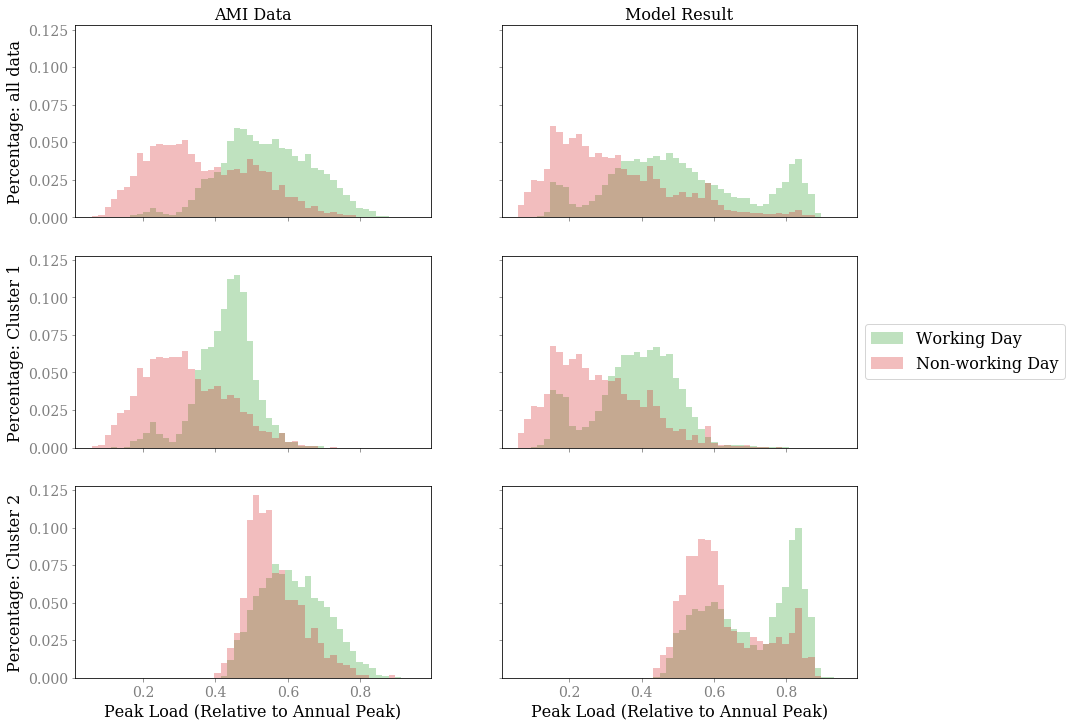

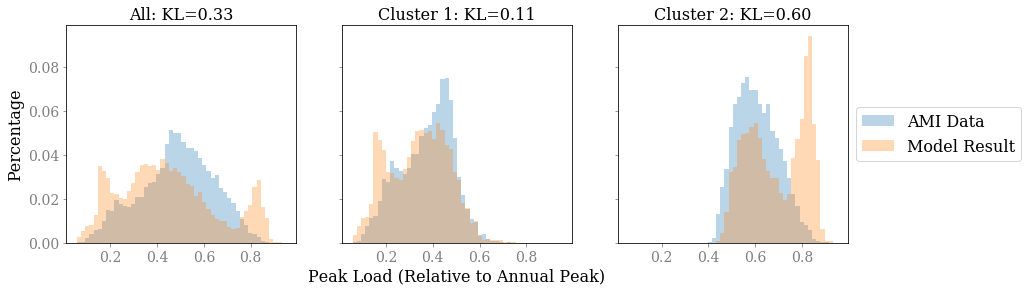

In [26]:
ami_data = ami_cluster_stat
model_data = model_cluster_stat
field = 'highLoad'

x_label = 'Peak Load (Relative to Annual Peak)'
y_label = 'Percentage'
figName = 'highLoad'

plot_dist(ami_data, model_data, field, x_label, y_label, figName)
compare_kl(ami_data, model_data, field, x_label, y_label, figName+'_kl')

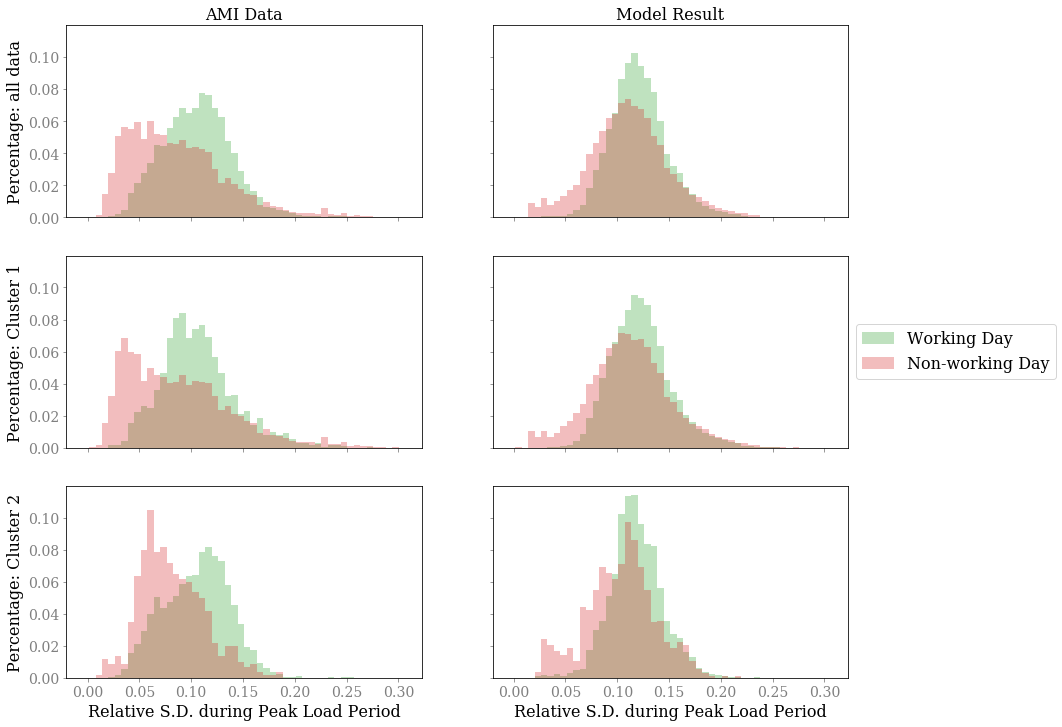

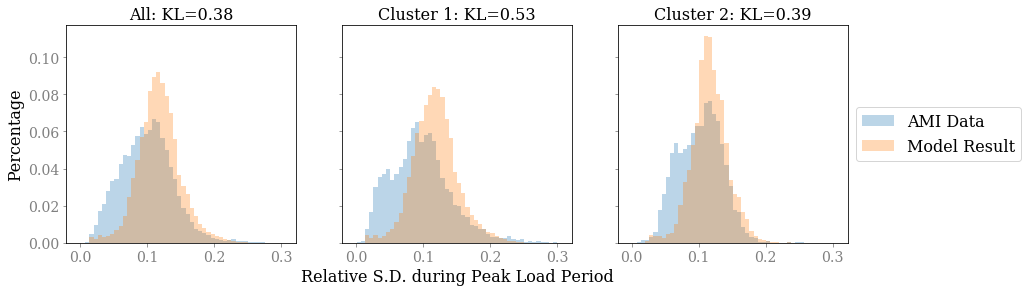

In [27]:
ami_data = ami_cluster_stat
model_data = model_cluster_stat
field = 'highLoad_SD'

x_label = 'Relative S.D. during Peak Load Period'
y_label = 'Percentage'
figName = 'highLoad_RSD'

plot_dist(ami_data, model_data, field, x_label, y_label, figName)
compare_kl(ami_data, model_data, field, x_label, y_label, figName+'_kl')

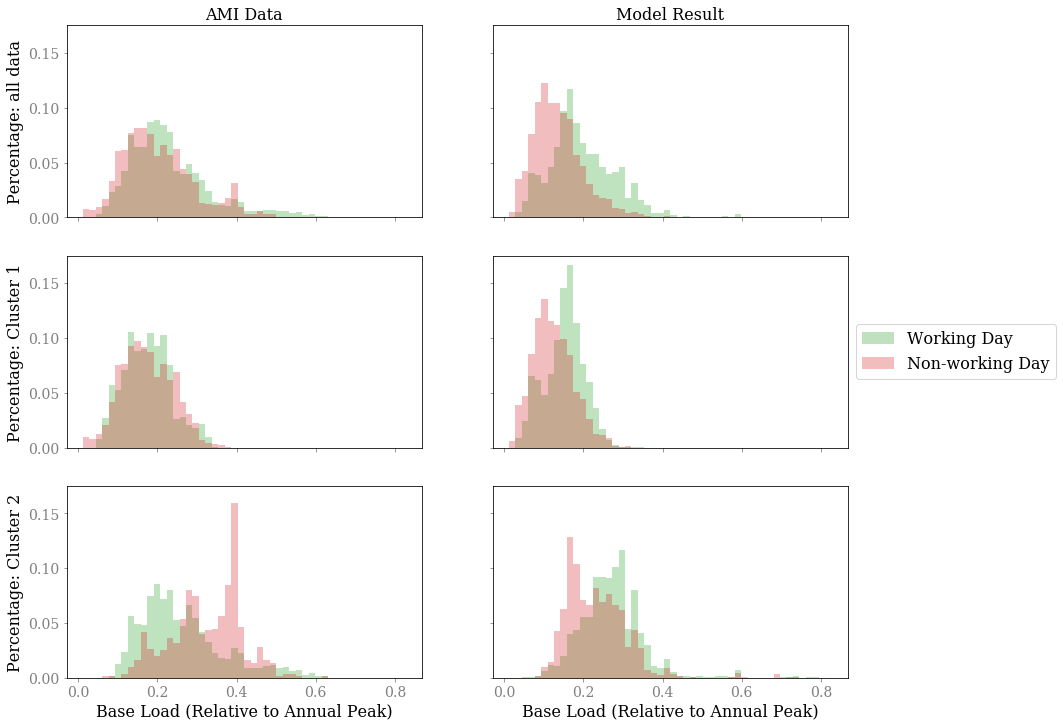

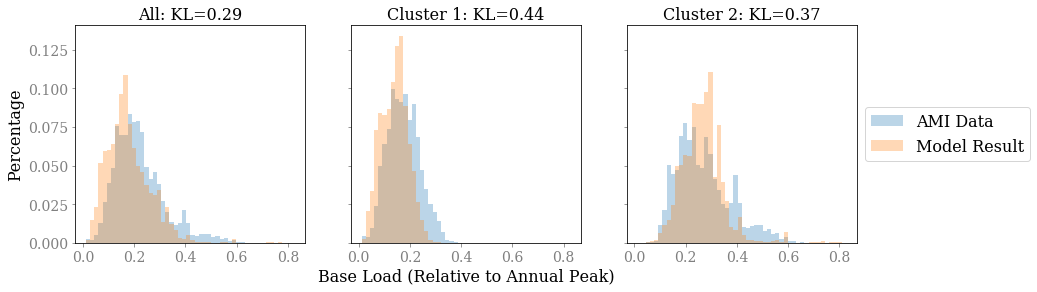

In [28]:
ami_data = ami_cluster_stat
model_data = model_cluster_stat
field = 'baseLoad'

x_label = 'Base Load (Relative to Annual Peak)'
y_label = 'Percentage'
figName = 'baseLoad'

plot_dist(ami_data, model_data, field, x_label, y_label, figName)
compare_kl(ami_data, model_data, field, x_label, y_label, figName+'_kl')

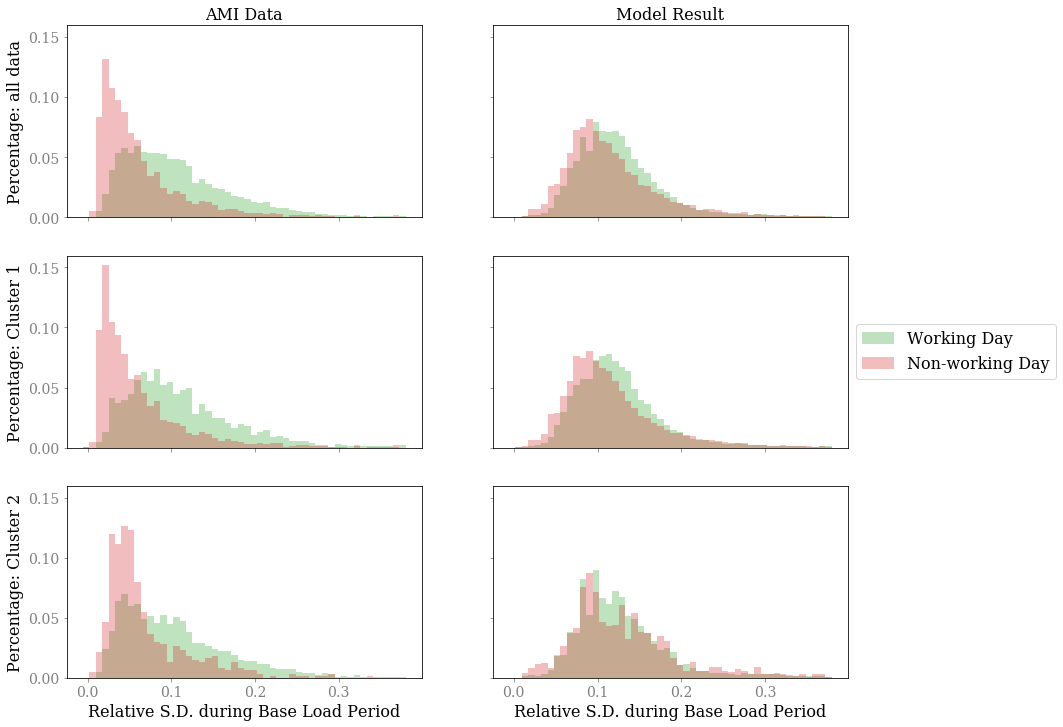

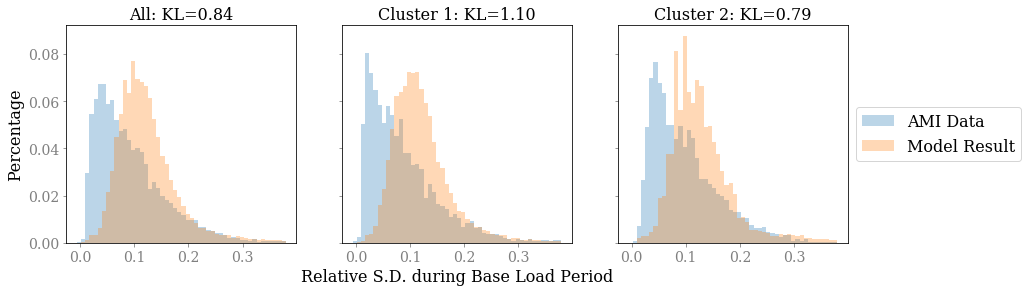

In [29]:
ami_data = ami_cluster_stat
model_data = model_cluster_stat
field = 'baseLoad_SD'

x_label = 'Relative S.D. during Base Load Period'
y_label = 'Percentage'
figName = 'baseLoad_RSD'

plot_dist(ami_data, model_data, field, x_label, y_label, figName, bins_method='99pct')
compare_kl(ami_data, model_data, field, x_label, y_label, figName+'_kl', bins_method='99pct')

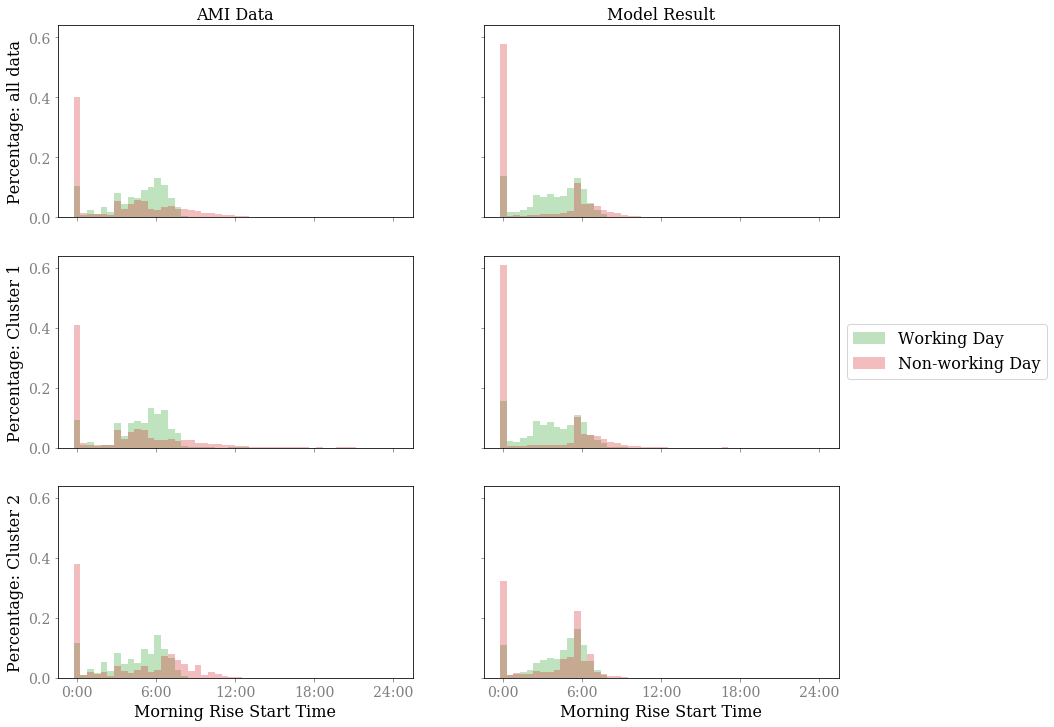

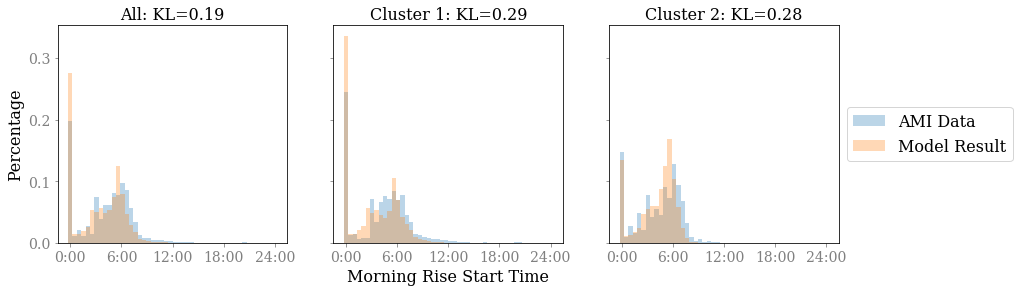

In [30]:
ami_data = ami_cluster_stat
model_data = model_cluster_stat

field = 'Morning Rise Start'

x_label = 'Morning Rise Start Time'
y_label = 'Percentage'
figName = field

plot_dist(ami_data, model_data, field, x_label, y_label, figName, time_stick=True)
compare_kl(ami_data, model_data, field, x_label, y_label, figName+'_kl', time_stick=True)

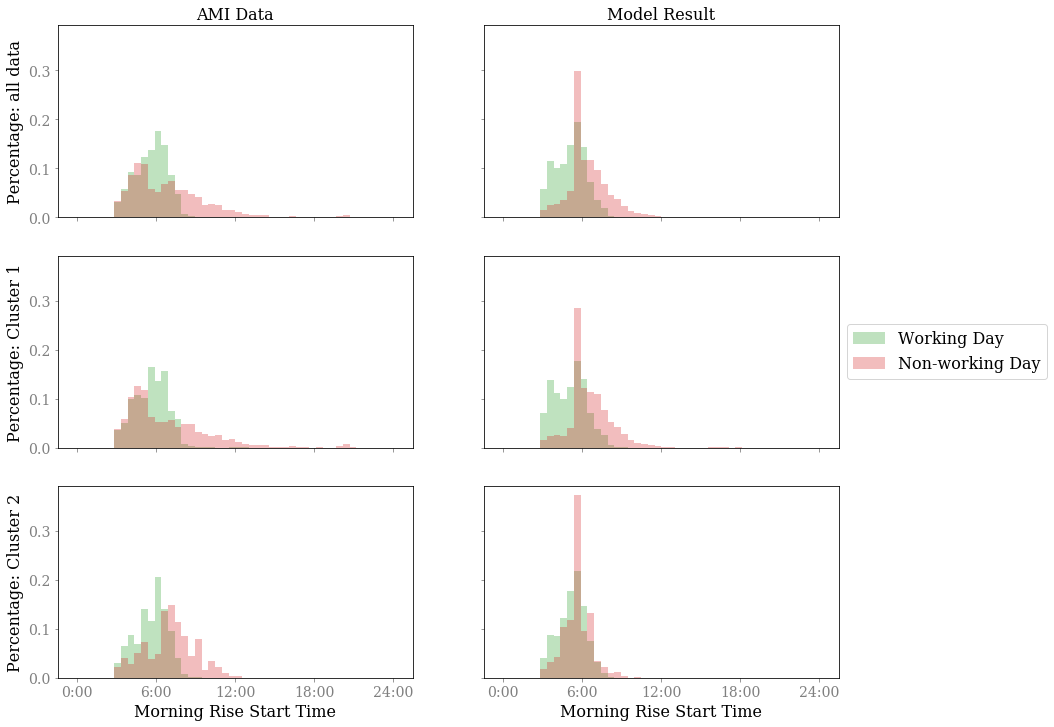

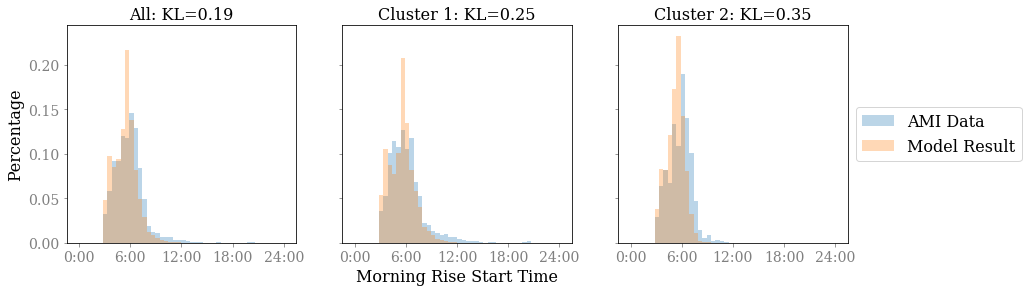

In [31]:
ami_data = ami_cluster_stat
model_data = model_cluster_stat

field = 'Morning Rise Start'

ami_data_filtered = ami_data[ami_data[field]>12]
model_data_filtered = model_data[model_data[field]>12]

x_label = 'Morning Rise Start Time'
y_label = 'Percentage'
figName = field+'_filtered'

plot_dist(ami_data_filtered, model_data_filtered, field, x_label, y_label, figName, time_stick=True)
compare_kl(ami_data_filtered, model_data_filtered, field, x_label, y_label, figName+'_kl', time_stick=True)

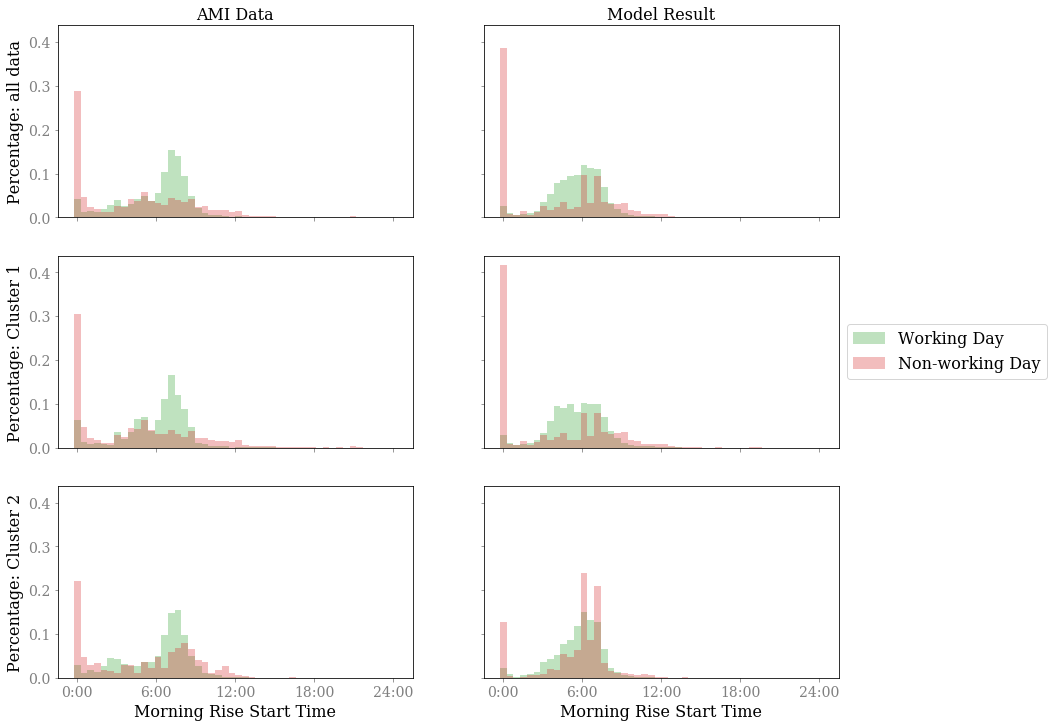

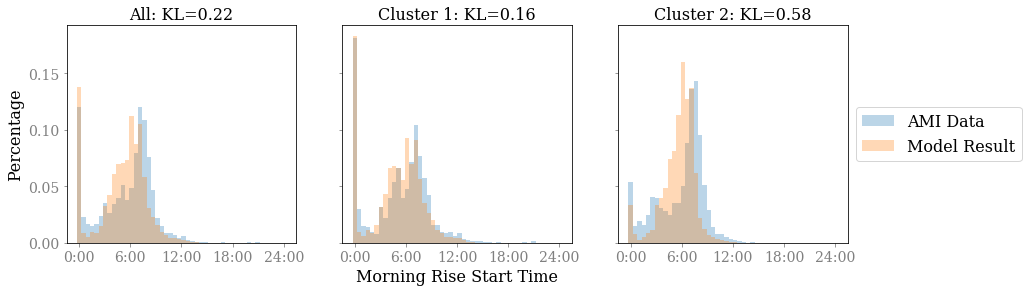

In [32]:
ami_data = ami_cluster_stat
model_data = model_cluster_stat

field = 'High Load Start'

x_label = 'Morning Rise Start Time'
y_label = 'Percentage'
figName = field

plot_dist(ami_data, model_data, field, x_label, y_label, figName, time_stick=True)
compare_kl(ami_data, model_data, field, x_label, y_label, figName+'_kl', time_stick=True)

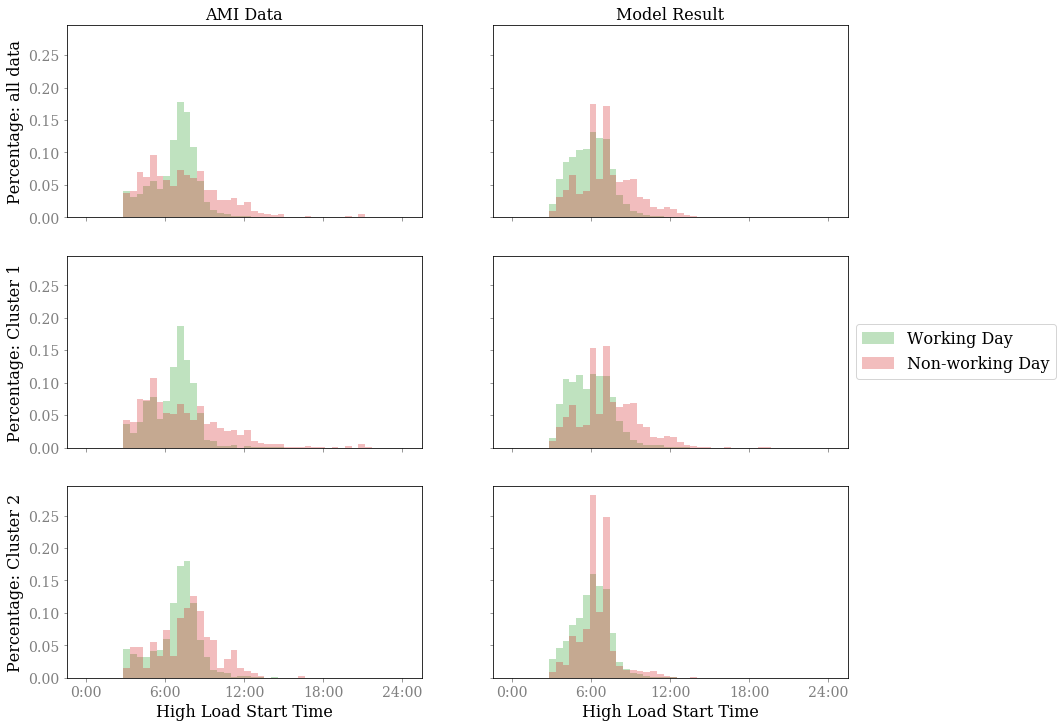

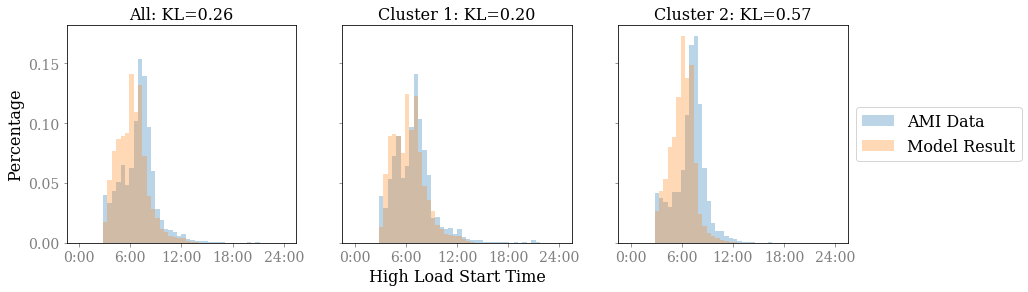

In [33]:
ami_data = ami_cluster_stat
model_data = model_cluster_stat

field = 'High Load Start'

ami_data_filtered = ami_data[ami_data[field]>12]
model_data_filtered = model_data[model_data[field]>12]

x_label = 'High Load Start Time'
y_label = 'Percentage'
figName = field+'_filtered'

plot_dist(ami_data_filtered, model_data_filtered, field, x_label, y_label, figName, time_stick=True)
compare_kl(ami_data_filtered, model_data_filtered, field, x_label, y_label, figName+'_kl', time_stick=True)

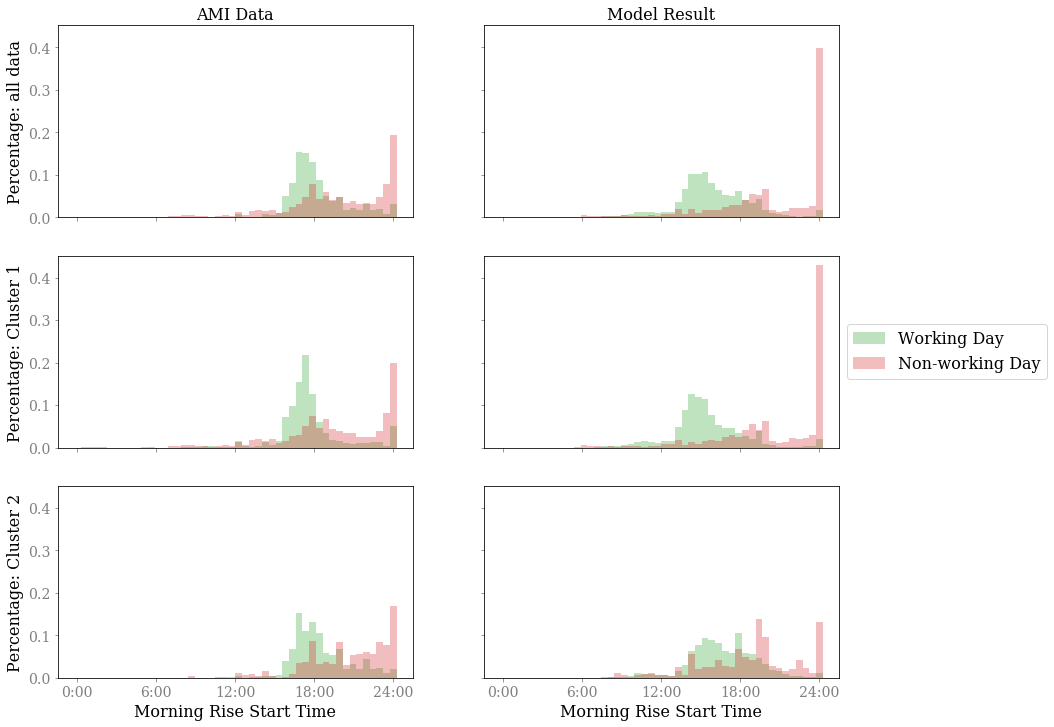

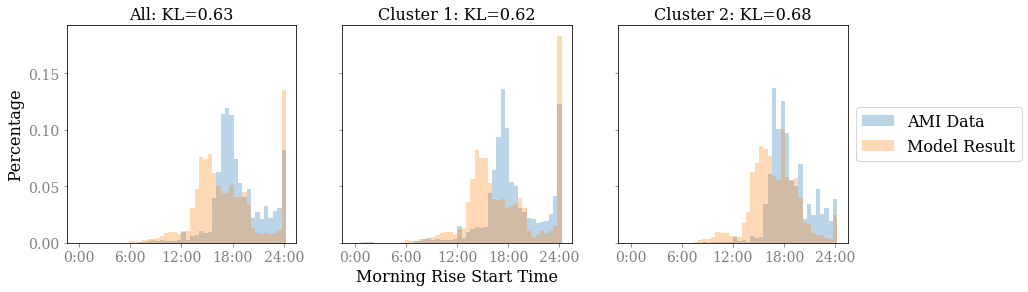

In [34]:
ami_data = ami_cluster_stat
model_data = model_cluster_stat

field = 'High Load Finish'

x_label = 'Morning Rise Start Time'
y_label = 'Percentage'
figName = field

plot_dist(ami_data, model_data, field, x_label, y_label, figName, time_stick=True)
compare_kl(ami_data, model_data, field, x_label, y_label, figName+'_kl', time_stick=True)

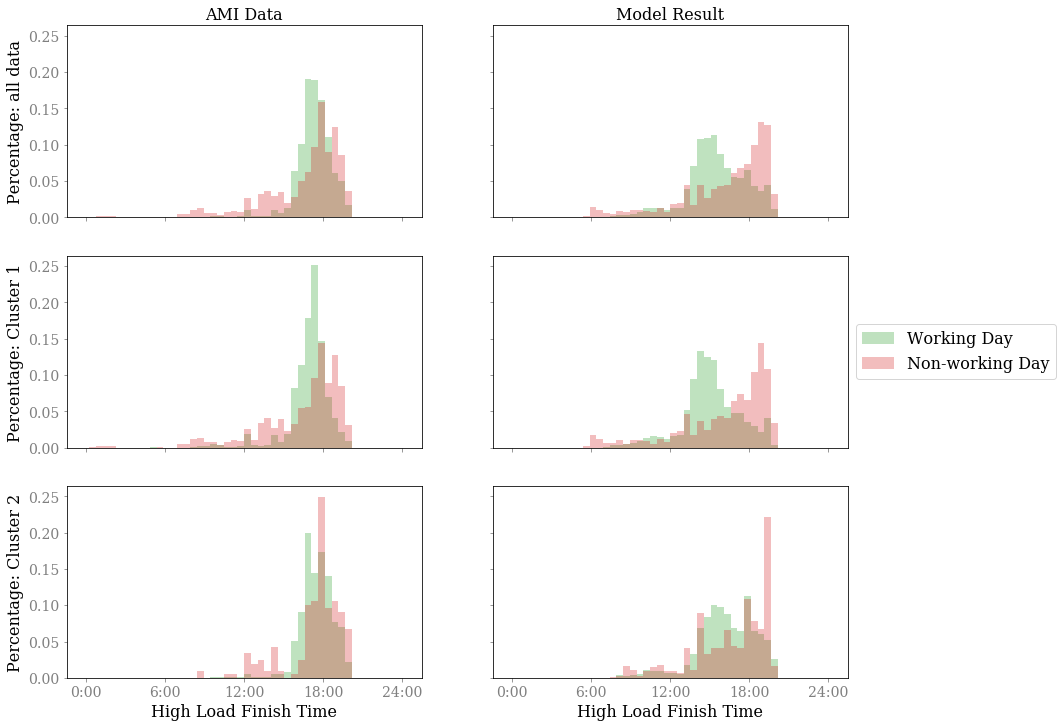

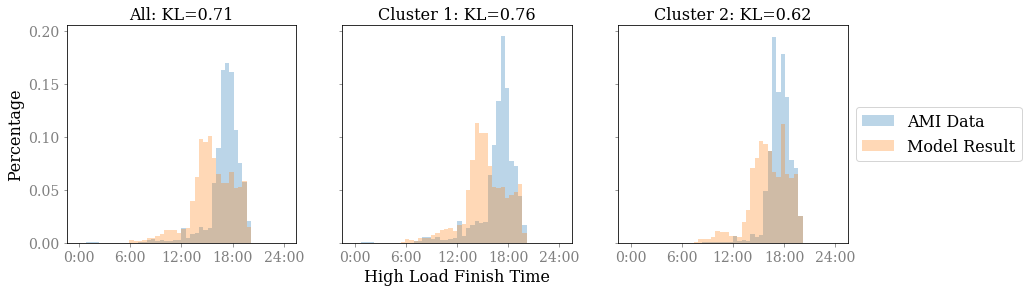

In [35]:
ami_data = ami_cluster_stat
model_data = model_cluster_stat

field = 'High Load Finish'

ami_data_filtered = ami_data[ami_data[field]<80]
model_data_filtered = model_data[model_data[field]<80]

x_label = 'High Load Finish Time'
y_label = 'Percentage'
figName = field+'_filtered'

plot_dist(ami_data_filtered, model_data_filtered, field, x_label, y_label, figName, time_stick=True)
compare_kl(ami_data_filtered, model_data_filtered, field, x_label, y_label, figName+'_kl', time_stick=True)

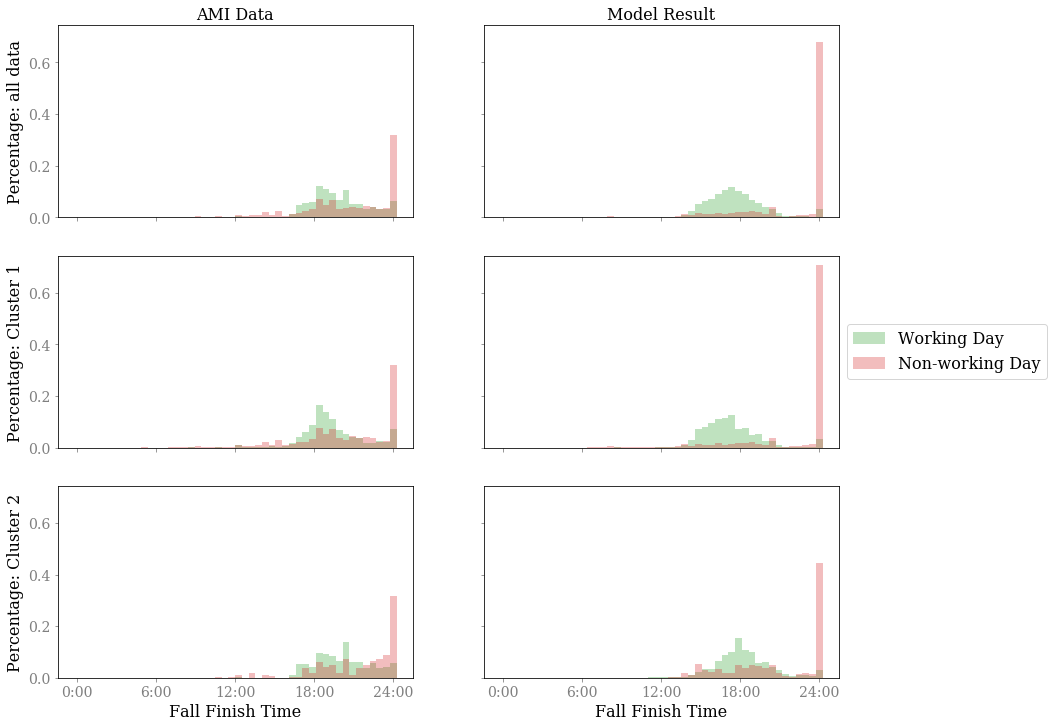

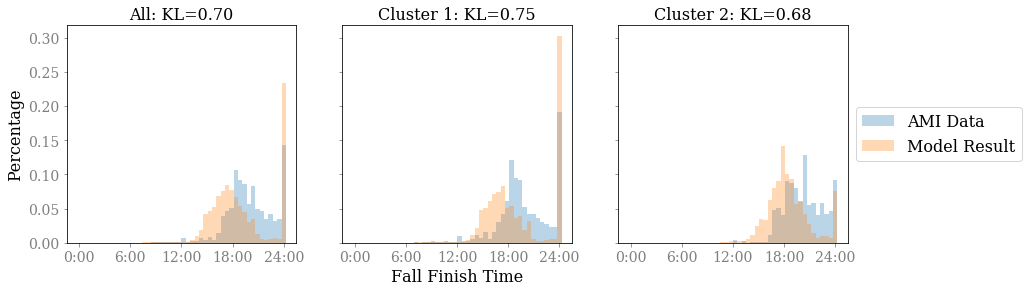

In [36]:
ami_data = ami_cluster_stat
model_data = model_cluster_stat

field = 'Afternoon Fall Finish'

x_label = 'Fall Finish Time'
y_label = 'Percentage'
figName = field

plot_dist(ami_data, model_data, field, x_label, y_label, figName, time_stick=True)
compare_kl(ami_data, model_data, field, x_label, y_label, figName+'_kl', time_stick=True)

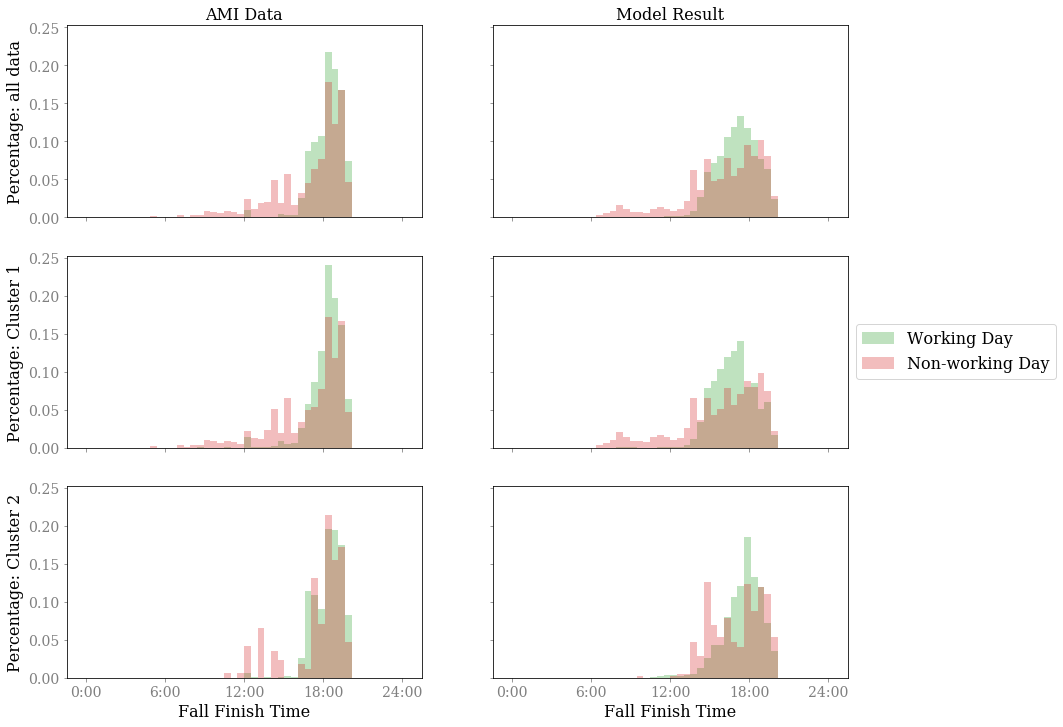

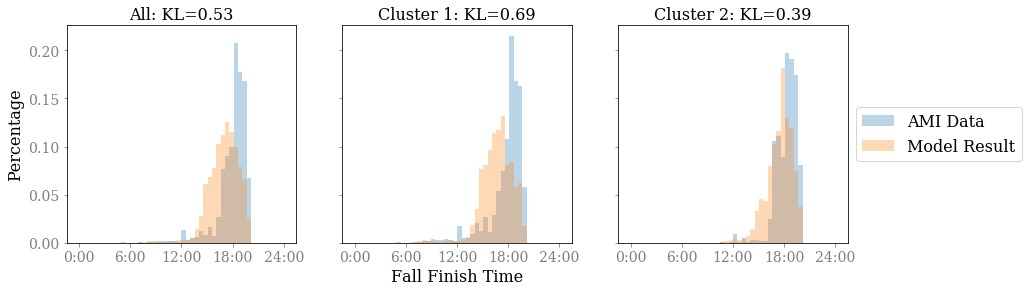

In [37]:
ami_data = ami_cluster_stat
model_data = model_cluster_stat

field = 'Afternoon Fall Finish'

ami_data_filtered = ami_data[ami_data[field]<80]
model_data_filtered = model_data[model_data[field]<80]

x_label = 'Fall Finish Time'
y_label = 'Percentage'
figName = field+'_filtered'

plot_dist(ami_data_filtered, model_data_filtered, field, x_label, y_label, figName, time_stick=True)
compare_kl(ami_data_filtered, model_data_filtered, field, x_label, y_label, figName+'_kl', time_stick=True)

## Calculate KL Divergence

In [38]:
ami_cluster_stat.head()

,highLoad,highLoad_SD,baseLoad,baseLoad_SD,Morning Rise Start,High Load Start,High Load Finish,Afternoon Fall Finish,highLoadDuration,riseTime,fallTime,Base To Peak Ratio,building_ID,data_type,date,day_of_week,holiday,2_clusters,non_working_day
0,0.588940,0.222031,0.131823,0.368521,15,16,35,76,4.75,0.25,10.25,0.223830,8604214001,ami,2017-01-01 00:00:00-07:00,Sunday,False,0,True
1,0.570546,0.223397,0.147210,0.248593,16,17,35,77,4.50,0.25,10.50,0.258016,8604214001,ami,2017-01-02 00:00:00-07:00,Monday,True,0,True
2,0.513951,0.169237,0.181224,0.186226,11,14,73,77,14.75,0.75,1.00,0.352610,8604214001,ami,2017-01-03 00:00:00-07:00,Tuesday,False,1,False
3,0.570950,0.124671,0.195151,0.198899,9,17,73,77,14.00,2.00,1.00,0.341800,8604214001,ami,2017-01-04 00:00:00-07:00,Wednesday,False,1,False
4,0.591188,0.186811,0.233529,0.208773,0,7,72,77,16.25,1.75,1.25,0.395016,8604214001,ami,2017-01-05 00:00:00-07:00,Thursday,False,1,False


In [39]:
ami_cluster_result.head()

,2_clusters,3_clusters,4_clusters,5_clusters,6_clusters,7_clusters,building_ID,data_type,date,day_of_week,holiday,non_working_day
0,0,0,1,1,1,2,8604214001,ami,2017-01-01 00:00:00-07:00,Sunday,False,True
1,0,0,1,1,1,2,8604214001,ami,2017-01-02 00:00:00-07:00,Monday,True,True
2,1,1,1,2,2,3,8604214001,ami,2017-01-03 00:00:00-07:00,Tuesday,False,False
3,1,1,2,2,3,4,8604214001,ami,2017-01-04 00:00:00-07:00,Wednesday,False,False
4,1,1,2,2,3,4,8604214001,ami,2017-01-05 00:00:00-07:00,Thursday,False,False
